In [26]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dedalus

+ Dedalus is a Python package for solving PDEs using spectral methods
+ Very recently published ([Burns et al Phys Rev Research 2019](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.023068))

+ Idea: specify our PDE in a high-level symbolic language, and then Dedalus will automatically generate optimized code to solve it

+ Requires a few hardware configurations and dependencies

+ Other "high-level" PDE solvers exist, especially for finite-element methods (Ansys, COMSOL, etc), but Dedalus is high quality, actively maintained (difficult to find in academic software), and completely open-source

#### Installation

+ Instructions [here](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html)
+ Dedalus has a lot of dependencies, so it's best to install it in a conda environment
+ On my Apple Silicon laptop, I had to use the [second set of instructions for custom conda installation here](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus

### The Kuramoto-Sivashinsky equation

+ A nonlinear PDE that is a relative of Burgers' equation that describes the dynamics of flame fronts

$$
\frac{\partial u}{\partial t} + \frac{\partial^4 u}{\partial x^4}+ \nu \frac{\partial^2 u}{\partial x^2} + u \frac{\partial u}{\partial x} = 0
$$


2022-10-14 00:00:43,425 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+01/s
2022-10-14 00:00:43,556 __main__ 0/1 INFO :: Iteration=500, Time=1.000000e+00, dt=2.000000e-03
2022-10-14 00:00:43,686 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2022-10-14 00:00:43,820 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2022-10-14 00:00:43,952 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2022-10-14 00:00:44,078 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2022-10-14 00:00:44,205 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2022-10-14 00:00:44,333 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2022-10-14 00:00:44,467 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2022-10-14 00:00:44,601 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2022-

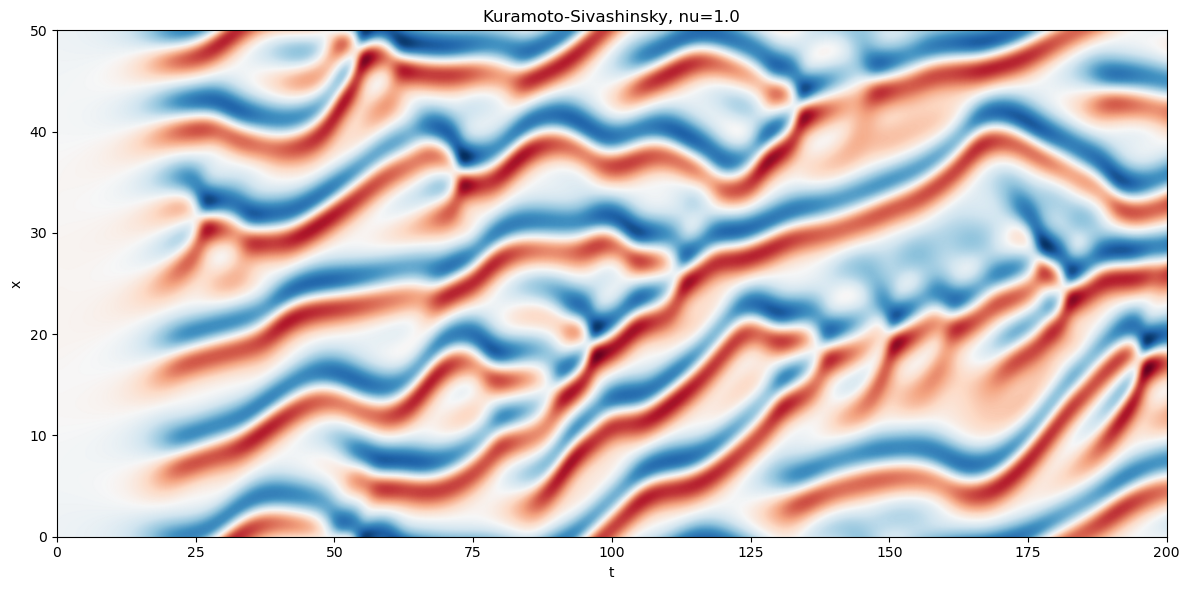

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


## Specify simulation parameters
Lx = 50
Nx = 1024
nu = 1e0
dealias = 3/2
stop_sim_time = 200
timestepper = d3.SBDF2
timestep = 2e-3
dtype = np.float64


## Set up bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias) # periodic basis

## Define dynamical Fields
u = dist.Field(name='u', bases=xbasis)

## Define operators
dx = lambda A: d3.Differentiate(A, xcoord)

## State PDE Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) + dx(dx(dx(dx(u)))) + nu * dx(dx(u)) = -u*dx(u)")


## Make random initial conditions that vanish at the boundaries
x = dist.local_grid(xbasis)
from scipy.ndimage import gaussian_filter1d
ic = gaussian_filter1d(np.random.random(x.shape), 10) * np.sin(np.pi * x / x[-1] )
dx_val = (2 * np.pi)/len(u['g'])
u['g'] = ic / (np.sum(ic) * dx_val)

## Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

## Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    if solver.iteration % 50 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

## Plotting
plt.figure(figsize=(12, 6))
plt.pcolormesh(np.array(t_list), x.ravel(), np.array(u_list).T, cmap='RdBu_r', shading='gouraud', rasterized=True)
plt.xlim(0, stop_sim_time)
plt.ylim(0, Lx)
plt.xlabel('t')
plt.ylabel('x')
plt.title(f'Kuramoto-Sivashinsky, nu={nu}')
plt.tight_layout()

### The Poisson equation with mixed boundary conditions

+ A 2D problem that is a relative of the Laplace equation, but with mixed boundary conditions

$$
\nabla^2 u(\mathbf{r}) = f(\mathbf{r})
$$



+ The top and bottom boundaries are Dirichlet, and the left and right boundaries are periodic

+ The current version of Dedalus requires boundary conditions to be specified via [the tau method](https://dedalus-project.readthedocs.io/en/latest/pages/tau_method.html)

+ This example is adapted from [the Dedalus tutorials](https://dedalus-project.readthedocs.io/en/latest/pages/tutorials.html)

2022-10-13 23:41:55,261 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 4s, Rate: 3.3e+01/s
2022-10-13 23:41:55,411 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 7.2e+01/s
2022-10-13 23:41:55,568 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 0s, Remaining: 1s, Rate: 7.7e+01/s
2022-10-13 23:41:55,731 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 1s, Remaining: 1s, Rate: 7.8e+01/s
2022-10-13 23:41:55,912 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 1s, Remaining: 1s, Rate: 7.6e+01/s
2022-10-13 23:41:56,090 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 1s, Remaining: 1s, Rate: 7.6e+01/s
2022-10-13 23:41:56,268 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 1s, Remaining: 1s, Rate: 7.5e+01/s
2022-10-13 23:41:56,436 subsystems 0/1 INFO :: Building subprobl

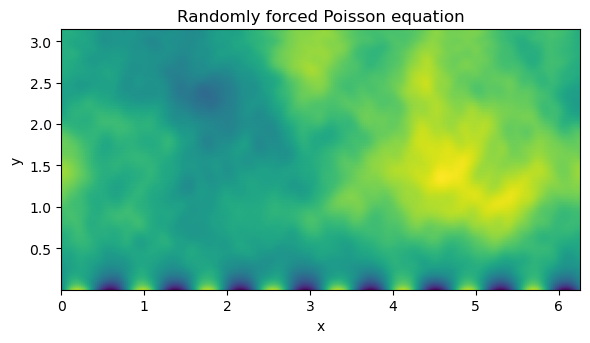

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Parameters
Lx, Ly = 2*np.pi, np.pi
Nx, Ny = 256, 128
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx))
ybasis = d3.Chebyshev(coords['y'], size=Ny, bounds=(0, Ly))

## Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

## Forcing
x, y = dist.local_grids(xbasis, ybasis)
f = dist.Field(bases=(xbasis, ybasis))
g = dist.Field(bases=xbasis)
h = dist.Field(bases=xbasis)
f.fill_random('g', seed=40)
f.low_pass_filter(shape=(64, 32))
g['g'] = np.sin(8*x) * 0.025
h['g'] = 0

# Substitutions
dy = lambda A: d3.Differentiate(A, coords['y'])
lift_basis = ybasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

## Specify PDE Problem. Notice that we need to add explicit boundary conditions
## along the y direction, since we have Dirichlet BCs there.
problem = d3.LBVP([u, tau_1, tau_2], namespace=locals())
# problem.add_equation("lap(u) = f")
problem.add_equation("lap(u) + lift(tau_1,-1) + lift(tau_2,-2) = f")
problem.add_equation("u(y=0) = g")
problem.add_equation("dy(u)(y=Ly) = h")

## Build and runSolver
solver = problem.build_solver()
solver.solve()

# Gather global data
x = xbasis.global_grid()
y = ybasis.global_grid()
ug = u.allgather_data('g')

# Plot
if dist.comm.rank == 0:
    plt.figure(figsize=(6, 4))
    plt.pcolormesh(x.ravel(), y.ravel(), ug.T, cmap='viridis', shading='gouraud', rasterized=True)
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Randomly forced Poisson equation")
    plt.tight_layout()
    plt.savefig('poisson.pdf')
    plt.savefig('poisson.png', dpi=200)